# 4 Modeling: CO2 Emission in Countries <a id='2_Processing_and_Training_Data'></a>

## 4.1 Introduction<a id='2.1_Introduction'></a>

Here comes the really fun step: modeling! For this step, you'll consider the types of models that would be appropriate to use given the features in your dataset and then dive right in and build two or three models. Please note: in addition to considering different algorithm types in your model selection, be sure to also consider applying model hyperparameter tuning operations.

## 4.2 Imports<a id='1.2_Imports'></a>

In [1]:
# Import functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import statsmodels.api as sm
import os
import pickle
import datetime
from library.sb_utils import save_file
from sklearn import datasets,linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, PolynomialFeatures, normalize
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, cross_val_score

pd.options.display.max_columns = 1000

In [2]:
# Define my own functions
# RMSE Calcuation
def rmse(y_true, y_pre):
    return (np.mean((y_pre-y_true)**2))**0.5

# Normalization
def norm(x):
    MIN = x.min()
    MAX = x.max()
    x_norm = x.apply(lambda x: (x-MIN)/(MAX-MIN))
    return(x_norm)    

In [3]:
# Define global variables
hypertable = []
df_coeff = pd.DataFrame()

In [4]:
co2_data_df = pd.read_csv('../data/co2_data_updated.csv')
co2_data_df.head()

,region_name,iso_code,country,year,annual_co2_prod_Megaton,primary_energy_consumption_10Gwh,population,gdp,Value_agri_1000hectare,Value_beef_tonnes,energy_isnan,gdp_isnan,population_isnan,argi_isnan,beef_isnan,primary_energy_consumption_gt_70k,primary_energy_consumption_gt_110k
0,Other,AFG,Afghanistan,1949-01-01,0.015,0.0,7663783.0,0.000000e+00,0.0,0.0,True,True,False,True,True,False,False
1,Other,AFG,Afghanistan,1950-01-01,0.084,0.0,7752000.0,1.949480e+10,0.0,0.0,True,False,False,True,True,False,False
2,Other,AFG,Afghanistan,1951-01-01,0.092,0.0,7840000.0,2.006385e+10,0.0,0.0,True,False,False,True,True,False,False
3,Other,AFG,Afghanistan,1952-01-01,0.092,0.0,7936000.0,2.074235e+10,0.0,0.0,True,False,False,True,True,False,False
4,Other,AFG,Afghanistan,1953-01-01,0.106,0.0,8040000.0,2.201546e+10,0.0,0.0,True,False,False,True,True,False,False


## 4.3 Modeling and Training

In [5]:
# use get.dummies on catagorical feature to generate numericla variables creat addtional columns
co2_data_df = co2_data_df.join(pd.get_dummies(co2_data_df['region_name'], prefix='dm', prefix_sep='_'))

In [6]:
co2_data_df['after_1850'] = co2_data_df['year'] >= '1850-10-10'

In [7]:
co2_data_df.head()

,region_name,iso_code,country,year,annual_co2_prod_Megaton,primary_energy_consumption_10Gwh,population,gdp,Value_agri_1000hectare,Value_beef_tonnes,energy_isnan,gdp_isnan,population_isnan,argi_isnan,beef_isnan,primary_energy_consumption_gt_70k,primary_energy_consumption_gt_110k,dm_Africa,dm_China,dm_Europe,dm_India,dm_Other,dm_Russia,dm_USA,after_1850
0,Other,AFG,Afghanistan,1949-01-01,0.015,0.0,7663783.0,0.000000e+00,0.0,0.0,True,True,False,True,True,False,False,0,0,0,0,1,0,0,True
1,Other,AFG,Afghanistan,1950-01-01,0.084,0.0,7752000.0,1.949480e+10,0.0,0.0,True,False,False,True,True,False,False,0,0,0,0,1,0,0,True
2,Other,AFG,Afghanistan,1951-01-01,0.092,0.0,7840000.0,2.006385e+10,0.0,0.0,True,False,False,True,True,False,False,0,0,0,0,1,0,0,True
3,Other,AFG,Afghanistan,1952-01-01,0.092,0.0,7936000.0,2.074235e+10,0.0,0.0,True,False,False,True,True,False,False,0,0,0,0,1,0,0,True
4,Other,AFG,Afghanistan,1953-01-01,0.106,0.0,8040000.0,2.201546e+10,0.0,0.0,True,False,False,True,True,False,False,0,0,0,0,1,0,0,True


In [8]:
co2_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 25 columns):
region_name                           23171 non-null object
iso_code                              20440 non-null object
country                               23171 non-null object
year                                  23171 non-null object
annual_co2_prod_Megaton               23171 non-null float64
primary_energy_consumption_10Gwh      23171 non-null float64
population                            23171 non-null float64
gdp                                   23171 non-null float64
Value_agri_1000hectare                23171 non-null float64
Value_beef_tonnes                     23171 non-null float64
energy_isnan                          23171 non-null bool
gdp_isnan                             23171 non-null bool
population_isnan                      23171 non-null bool
argi_isnan                            23171 non-null bool
beef_isnan                            23171 non-null 

In [9]:
# save the data to a new csv file
datapath = '../data'
save_file(co2_data_df, 'co2_data_updated2.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../data\co2_data_updated2.csv"


In [10]:
co2_data_df.columns

Index(['region_name', 'iso_code', 'country', 'year', 'annual_co2_prod_Megaton',
       'primary_energy_consumption_10Gwh', 'population', 'gdp',
       'Value_agri_1000hectare', 'Value_beef_tonnes', 'energy_isnan',
       'gdp_isnan', 'population_isnan', 'argi_isnan', 'beef_isnan',
       'primary_energy_consumption_gt_70k',
       'primary_energy_consumption_gt_110k', 'dm_Africa', 'dm_China',
       'dm_Europe', 'dm_India', 'dm_Other', 'dm_Russia', 'dm_USA',
       'after_1850'],
      dtype='object')

In [11]:
feature_names = ['primary_energy_consumption_10Gwh','gdp','population','Value_agri_1000hectare','Value_beef_tonnes',
                 'energy_isnan','gdp_isnan','population_isnan','argi_isnan','beef_isnan',
                 'primary_energy_consumption_gt_70k','primary_energy_consumption_gt_110k',
                'dm_Africa','dm_China', 'dm_Europe', 'dm_India', 'dm_Russia', 'dm_USA',
                'after_1850']

### 4.3.1 Multivariate Linear Regression

In [12]:
# build training dataset
x_fea_5 = co2_data_df[feature_names]
y_fea_5 = co2_data_df['annual_co2_prod_Megaton']
# print(x_fea_5,'\n\n\n',y_fea_5)
x_fea_5_train,x_fea_5_test,y_fea_5_train,y_fea_5_test = train_test_split(x_fea_5,y_fea_5,test_size=0.3,random_state=47)

In [13]:
# train the model
ml_fea_5 = LinearRegression(fit_intercept=True, normalize=True)
ml_fea_5.fit(x_fea_5_train,y_fea_5_train)

# predict
y_fea_5_pred_train = ml_fea_5.predict(x_fea_5_train)
 # print(y_afr_pred_train)
y_fea_5_pred_test = ml_fea_5.predict(x_fea_5_test)
 # print(y_afr_pred_test)
    
# calculate r2
ml_fea_5_r2_train = r2_score(y_fea_5_train,y_fea_5_pred_train)
print(ml_fea_5_r2_train)
ml_fea_5_r2_test = r2_score(y_fea_5_test,y_fea_5_pred_test)
print(ml_fea_5_r2_test)

# cross_validation
# cvscores_fea_5 = cross_val_score(ml_fea_5,x_fea_5,y_fea_5,cv=10,scoring = 'r2')
# print(cvscores_fea_5)
# do cv mannually similiar to time series, make sure data set represent samples. stratefied train test split.
# dont use cv automaticaly
# in future study using auto cv is not helpful put into report.

0.854438596316489
0.8734222005937151


In [14]:
# add results to hypertable
results = {}
results['r2_train'] = ml_fea_5_r2_train
results['rmse_train'] = rmse(y_fea_5_train,y_fea_5_pred_train)
results['r2_test'] = ml_fea_5_r2_test
results['rmse_test'] = rmse(y_fea_5_test,y_fea_5_pred_test)
results['alpha'] = 0
results['coef'] = ml_fea_5.coef_
results['incpt'] = ml_fea_5.intercept_                       
results['model'] = ml_fea_5.__class__.__name__
results['features'] = feature_names
results['description'] = 'Linear'
                       
hypertable.extend([results])
pd.DataFrame(hypertable).sort_values('r2_test')

,r2_train,rmse_train,r2_test,rmse_test,alpha,coef,incpt,model,features,description
0,0.854439,554.310706,0.873422,581.648314,0,"[0.08454048575419701, 1.9359139515350814e-11, ...",-532.319746,LinearRegression,"[primary_energy_consumption_10Gwh, gdp, popula...",Linear


In [15]:
df_coeff['features'] = feature_names

In [16]:
df_coeff['Linear']=ml_fea_5.coef_
df_coeff

,features,Linear
0,primary_energy_consumption_10Gwh,8.454049e-02
1,gdp,1.935914e-11
2,population,2.847385e-06
3,Value_agri_1000hectare,-2.105795e-03
4,Value_beef_tonnes,2.762239e-04
5,energy_isnan,1.272598e+01
6,gdp_isnan,4.864060e+01
7,population_isnan,6.493417e+02
8,argi_isnan,6.596098e+01
9,beef_isnan,-1.076728e+01


In [17]:
coefs_rgns = hypertable[0]['coef']
coefs_rgns = pd.Series(dict(zip(list(feature_names), list(coefs_rgns)))).sort_values()
coefs_rgns

primary_energy_consumption_gt_70k    -6.287009e+03
primary_energy_consumption_gt_110k   -2.342269e+03
dm_India                             -1.295726e+03
dm_China                             -1.016188e+03
beef_isnan                           -1.076728e+01
Value_agri_1000hectare               -2.105795e-03
gdp                                   1.935914e-11
population                            2.847385e-06
Value_beef_tonnes                     2.762239e-04
primary_energy_consumption_10Gwh      8.454049e-02
dm_Africa                             6.287782e+00
energy_isnan                          1.272598e+01
dm_Europe                             1.855455e+01
gdp_isnan                             4.864060e+01
argi_isnan                            6.596098e+01
dm_Russia                             2.499652e+02
after_1850                            4.824765e+02
population_isnan                      6.493417e+02
dm_USA                                1.140448e+03
dtype: float64

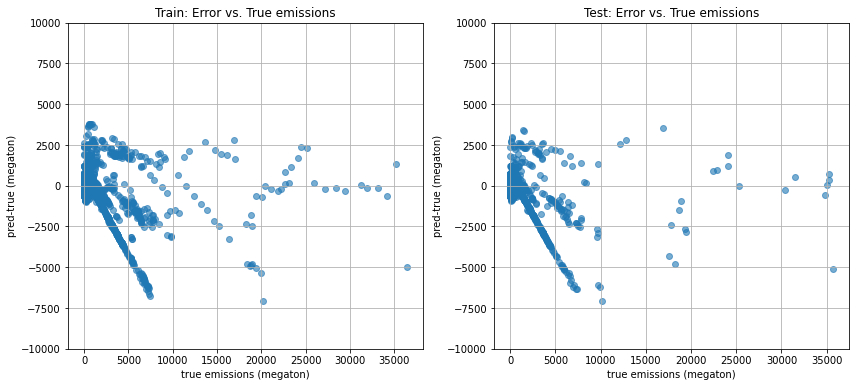

In [18]:
# plot the results
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.scatter(x=y_fea_5_train,y=(y_fea_5_pred_train-y_fea_5_train),alpha=0.6) #/y_fea_5_train
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Train: Error vs. True emissions')
plt.ylim([-10000,10000])
plt.grid('on')

plt.subplot(122)
plt.scatter(x=y_fea_5_test,y=(y_fea_5_pred_test-y_fea_5_test),alpha=0.6) #/y_fea_5_test
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Test: Error vs. True emissions')
plt.ylim([-10000,10000])
plt.grid('on')

### 4.3.2 scikit-learn regression Lasso

In [19]:
# https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [20]:
# build training dataset
x_rgns = co2_data_df[feature_names]
y_rgns = co2_data_df['annual_co2_prod_Megaton']
# print(x_fea_5,'\n\n\n',y_fea_5)
x_rgns_train,x_rgns_test,y_rgns_train,y_rgns_test = train_test_split(x_rgns,y_rgns,test_size=0.3,random_state=47)

In [21]:
alpha_space = np.logspace(-5, 0, num=10, base=10)
lasso_rgns_train_scores = []
lasso_rgns_test_scores = []
lassol_rgns_cv_scores = []

In [22]:
for alp in alpha_space:
    lasso_rgns = Lasso(alpha=alp, 
                       fit_intercept=True, 
                       normalize=True, 
                       selection='cyclic', 
                       max_iter=10000, 
                       tol=0.0001, 
                       warm_start=False)
    
    lasso_rgns.fit(x_rgns_train,y_rgns_train)
    # predict
    y_rgns_lasso_pred_train = lasso_rgns.predict(x_rgns_train)

    y_rgns_lasso_pred_test = lasso_rgns.predict(x_rgns_test)
    # calculate r2
    lasso_rgns_r2_train = r2_score(y_rgns_train,y_rgns_lasso_pred_train)
    lasso_rgns_train_scores.append(lasso_rgns_r2_train)
    lasso_rgns_r2_test = r2_score(y_rgns_test,y_rgns_lasso_pred_test)
    lasso_rgns_test_scores.append(lasso_rgns_r2_test)
   
    
    # add results to hypertable
    results = {}
    results['r2_train'] = lasso_rgns_r2_train
    results['rmse_train'] = rmse(y_rgns_train,y_rgns_lasso_pred_train)
    results['r2_test'] = lasso_rgns_r2_test
    results['rmse_test'] = rmse(y_rgns_test,y_rgns_lasso_pred_test)
    results['alpha'] = alp
    results['coef'] = lasso_rgns.coef_    
    results['incpt'] = lasso_rgns.intercept_                       
    results['model'] = lasso_rgns.__class__.__name__
    results['features'] = feature_names
    results['description'] = 'Lasso'

    hypertable.extend([results])
    pd.DataFrame(hypertable).sort_values('r2_test')
    
    text = 'Lasso_a_{}'.format(alp)
    df_coeff[text]=ml_fea_5.coef_

Text(0, 0.5, 'Scores')

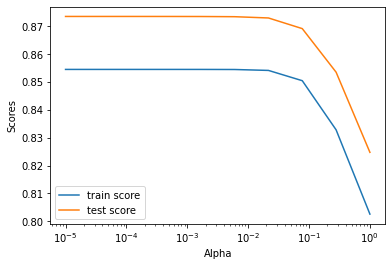

In [23]:
#plot the results
plt.plot(alpha_space,lasso_rgns_train_scores,label='train score')
plt.plot(alpha_space,lasso_rgns_test_scores,label='test score')
#plt.plot(alpha_space,lassol_rgns_cv_scores,label='CV score')
plt.xscale('log') 
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Scores')
# plt.title('Train: Error vs. True emissions')

In [24]:
pd.DataFrame(hypertable)

,r2_train,rmse_train,r2_test,rmse_test,alpha,coef,incpt,model,features,description
0,0.854439,554.310706,0.873422,581.648314,0.000000,"[0.08454048575419701, 1.9359139515350814e-11, ...",-532.319746,LinearRegression,"[primary_energy_consumption_10Gwh, gdp, popula...",Linear
1,0.854439,554.310706,0.873422,581.648593,0.000010,"[0.08453768073426157, 1.9355067205646733e-11, ...",-532.303316,Lasso,"[primary_energy_consumption_10Gwh, gdp, popula...",Lasso
2,0.854439,554.310709,0.873422,581.649320,0.000036,"[0.0845303730411766, 1.9344552045628567e-11, 2...",-532.260694,Lasso,"[primary_energy_consumption_10Gwh, gdp, popula...",Lasso
3,0.854439,554.310745,0.873421,581.651957,0.000129,"[0.08450416300287546, 1.9306684406229702e-11, ...",-532.107527,Lasso,"[primary_energy_consumption_10Gwh, gdp, popula...",Lasso
4,0.854438,554.311216,0.873416,581.661773,0.000464,"[0.08441000249701183, 1.917054532969842e-11, 2...",-531.557077,Lasso,"[primary_energy_consumption_10Gwh, gdp, popula...",Lasso
5,0.854435,554.316733,0.873400,581.700174,0.001668,"[0.08407974291640719, 1.8680068176007156e-11, ...",-529.550357,Lasso,"[primary_energy_consumption_10Gwh, gdp, popula...",Lasso
6,0.854409,554.367402,0.873330,581.859745,0.005995,"[0.08298682791561626, 1.6959121007111765e-11, ...",-521.854730,Lasso,"[primary_energy_consumption_10Gwh, gdp, popula...",Lasso
7,0.854081,554.991671,0.872876,582.902183,0.021544,"[0.0791304698134719, 1.0780811145548717e-11, 2...",-497.914258,Lasso,"[primary_energy_consumption_10Gwh, gdp, popula...",Lasso
8,0.850398,561.950915,0.869061,591.583474,0.077426,"[0.06360769983113357, 1.4759181627365153e-12, ...",-430.591261,Lasso,"[primary_energy_consumption_10Gwh, gdp, popula...",Lasso
9,0.832797,594.089542,0.853453,625.850001,0.278256,"[0.02968421610836768, 3.004667398496518e-11, 2...",-202.098340,Lasso,"[primary_energy_consumption_10Gwh, gdp, popula...",Lasso


In [25]:
df_coeff

,features,Linear,Lasso_a_1e-05,Lasso_a_3.5938136638046256e-05,Lasso_a_0.0001291549665014884,Lasso_a_0.0004641588833612782,Lasso_a_0.0016681005372000592,Lasso_a_0.005994842503189409,Lasso_a_0.021544346900318846,Lasso_a_0.07742636826811278,Lasso_a_0.2782559402207126,Lasso_a_1.0
0,primary_energy_consumption_10Gwh,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02
1,gdp,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11
2,population,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06
3,Value_agri_1000hectare,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03
4,Value_beef_tonnes,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04
5,energy_isnan,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01
6,gdp_isnan,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01
7,population_isnan,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02
8,argi_isnan,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01
9,beef_isnan,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01


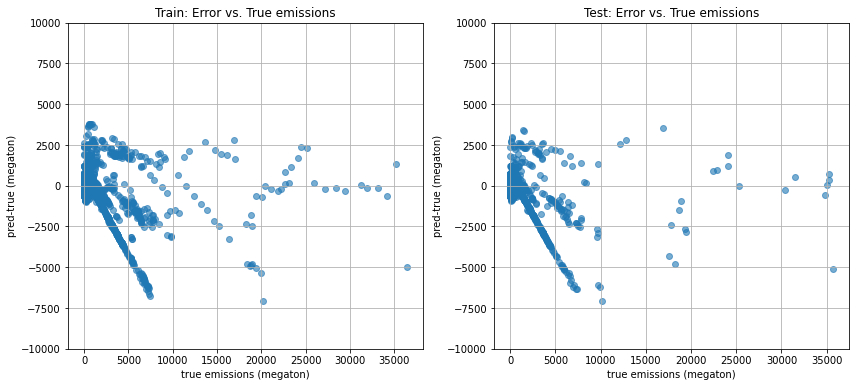

In [26]:
lasso_rgns = Lasso(alpha=0.00001, 
                   fit_intercept=True, 
                   normalize=True, 
                   selection='cyclic', 
                   max_iter=10000, 
                   tol=0.0001, 
                   warm_start=False)

lasso_rgns.fit(x_rgns_train,y_rgns_train)
# predict
y_rgns_lasso_pred_train = lasso_rgns.predict(x_rgns_train)
y_rgns_lasso_pred_test = lasso_rgns.predict(x_rgns_test)

# plot the results
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.scatter(x=y_rgns_train,y=(y_rgns_lasso_pred_train-y_rgns_train),alpha=0.6) #/y_fea_5_train
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Train: Error vs. True emissions')
plt.ylim([-10000,10000])
plt.grid('on')

plt.subplot(122)
plt.scatter(x=y_rgns_test,y=(y_rgns_lasso_pred_test-y_rgns_test),alpha=0.6) #/y_fea_5_test
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Test: Error vs. True emissions')
plt.ylim([-10000,10000])
plt.grid('on')

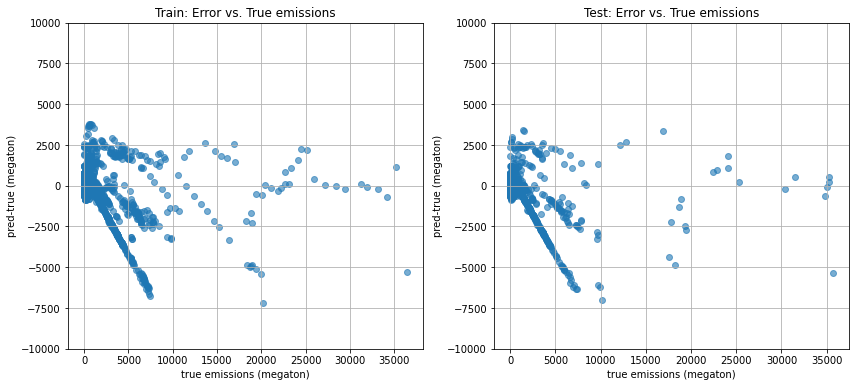

In [27]:
lasso_rgns = Lasso(alpha=0.01, 
                   fit_intercept=True, 
                   normalize=True, 
                   selection='cyclic', 
                   max_iter=10000, 
                   tol=0.0001, 
                   warm_start=False)

lasso_rgns.fit(x_rgns_train,y_rgns_train)
# predict
y_rgns_lasso_pred_train = lasso_rgns.predict(x_rgns_train)
y_rgns_lasso_pred_test = lasso_rgns.predict(x_rgns_test)

# plot the results
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.scatter(x=y_rgns_train,y=(y_rgns_lasso_pred_train-y_rgns_train),alpha=0.6) #/y_fea_5_train
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Train: Error vs. True emissions')
plt.ylim([-10000,10000])
plt.grid('on')

plt.subplot(122)
plt.scatter(x=y_rgns_test,y=(y_rgns_lasso_pred_test-y_rgns_test),alpha=0.6) #/y_fea_5_test
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Test: Error vs. True emissions')
plt.ylim([-10000,10000])
plt.grid('on')

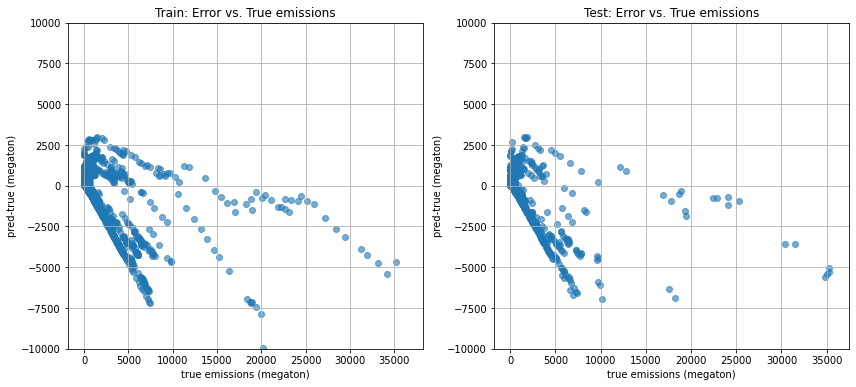

In [28]:
lasso_rgns = Lasso(alpha=1, 
                   fit_intercept=True, 
                   normalize=True, 
                   selection='cyclic', 
                   max_iter=10000, 
                   tol=0.0001, 
                   warm_start=False)

lasso_rgns.fit(x_rgns_train,y_rgns_train)
# predict
y_rgns_lasso_pred_train = lasso_rgns.predict(x_rgns_train)
y_rgns_lasso_pred_test = lasso_rgns.predict(x_rgns_test)

# plot the results
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.scatter(x=y_rgns_train,y=(y_rgns_lasso_pred_train-y_rgns_train),alpha=0.6) #/y_fea_5_train
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Train: Error vs. True emissions')
plt.ylim([-10000,10000])
plt.grid('on')

plt.subplot(122)
plt.scatter(x=y_rgns_test,y=(y_rgns_lasso_pred_test-y_rgns_test),alpha=0.6) #/y_fea_5_test
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Test: Error vs. True emissions')
plt.ylim([-10000,10000])
plt.grid('on')

### 4.3.2 scikit-learn regression Ridge

In [29]:
alpha_space = np.logspace(-5, 0, num=10, base=10)
ridge_rgns_train_scores = []
ridge_rgns_test_scores = []
ridge_rgns_cv_scores = []

In [30]:
for alp in alpha_space:
    ridge_rgns = Ridge(alpha=alp, 
                       fit_intercept=True, 
                       normalize=True)
    
    ridge_rgns.fit(x_rgns_train,y_rgns_train)
    # predict
    y_rgns_ridge_pred_train = ridge_rgns.predict(x_rgns_train)

    y_rgns_ridge_pred_test = ridge_rgns.predict(x_rgns_test)
    # calculate r2
    ridge_rgns_r2_train = r2_score(y_rgns_train,y_rgns_ridge_pred_train)
    ridge_rgns_train_scores.append(ridge_rgns_r2_train)
    ridge_rgns_r2_test = r2_score(y_rgns_test,y_rgns_ridge_pred_test)
    ridge_rgns_test_scores.append(ridge_rgns_r2_test)
   
    
    # add results to hypertable
    results = {}
    results['r2_train'] = ridge_rgns_r2_train
    results['rmse_train'] = rmse(y_rgns_train,y_rgns_ridge_pred_train)
    results['r2_test'] = ridge_rgns_r2_test
    results['rmse_test'] = rmse(y_rgns_test,y_rgns_ridge_pred_test)
    results['alpha'] = alp
    results['coef'] = ridge_rgns.coef_    
    results['incpt'] = ridge_rgns.intercept_                       
    results['model'] = ridge_rgns.__class__.__name__
    results['features'] = feature_names
    results['description'] = 'Ridge'

    hypertable.extend([results])
    pd.DataFrame(hypertable).sort_values('r2_test')
    
    text = 'Ridge_a_{}'.format(alp)
    df_coeff[text]=ml_fea_5.coef_


Text(0, 0.5, 'Scores')

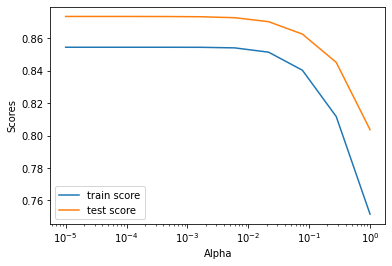

In [31]:
#plot the results
plt.plot(alpha_space,ridge_rgns_train_scores,label='train score')
plt.plot(alpha_space,ridge_rgns_test_scores,label='test score')
#plt.plot(alpha_space,ridgel_rgns_cv_scores,label='CV score')
plt.xscale('log') 
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Scores')
# plt.title('Train: Error vs. True emissions')


In [32]:
pd.DataFrame(hypertable).sort_values('r2_test',ascending=False)

,r2_train,rmse_train,r2_test,rmse_test,alpha,coef,incpt,model,features,description
0,0.854439,554.310706,0.873422,581.648314,0.000000,"[0.08454048575419701, 1.9359139515350814e-11, ...",-532.319746,LinearRegression,"[primary_energy_consumption_10Gwh, gdp, popula...",Linear
1,0.854439,554.310706,0.873422,581.648593,0.000010,"[0.08453768073426157, 1.9355067205646733e-11, ...",-532.303316,Lasso,"[primary_energy_consumption_10Gwh, gdp, popula...",Lasso
2,0.854439,554.310709,0.873422,581.649320,0.000036,"[0.0845303730411766, 1.9344552045628567e-11, 2...",-532.260694,Lasso,"[primary_energy_consumption_10Gwh, gdp, popula...",Lasso
11,0.854439,554.310709,0.873421,581.650805,0.000010,"[0.08451290205014751, 1.9400114109015723e-11, ...",-532.309051,Ridge,"[primary_energy_consumption_10Gwh, gdp, popula...",Ridge
3,0.854439,554.310745,0.873421,581.651957,0.000129,"[0.08450416300287546, 1.9306684406229702e-11, ...",-532.107527,Lasso,"[primary_energy_consumption_10Gwh, gdp, popula...",Lasso
12,0.854439,554.310741,0.873418,581.657275,0.000036,"[0.08444148681225559, 1.9506156479018612e-11, ...",-532.281310,Ridge,"[primary_energy_consumption_10Gwh, gdp, popula...",Ridge
4,0.854438,554.311216,0.873416,581.661773,0.000464,"[0.08441000249701183, 1.917054532969842e-11, 2...",-531.557077,Lasso,"[primary_energy_consumption_10Gwh, gdp, popula...",Lasso
13,0.854438,554.311152,0.873408,581.680651,0.000129,"[0.08418639284122888, 1.9884436484264762e-11, ...",-532.181613,Ridge,"[primary_energy_consumption_10Gwh, gdp, popula...",Ridge
5,0.854435,554.316733,0.873400,581.700174,0.001668,"[0.08407974291640719, 1.8680068176007156e-11, ...",-529.550357,Lasso,"[primary_energy_consumption_10Gwh, gdp, popula...",Lasso
14,0.854436,554.316371,0.873371,581.766182,0.000464,"[0.08328929111930322, 2.1208433782079902e-11, ...",-531.823317,Ridge,"[primary_energy_consumption_10Gwh, gdp, popula...",Ridge


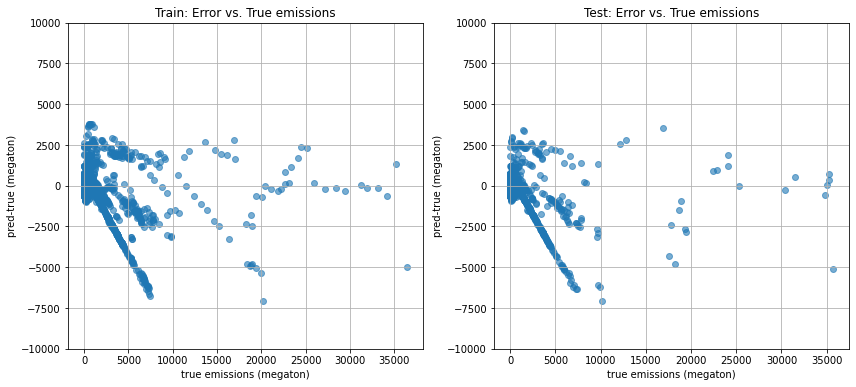

In [33]:
ridge_rgns = Ridge(alpha=0.00001, 
                   fit_intercept=True, 
                   normalize=True)

ridge_rgns.fit(x_rgns_train,y_rgns_train)
# predict
y_rgns_ridge_pred_train = ridge_rgns.predict(x_rgns_train)
y_rgns_ridge_pred_test = ridge_rgns.predict(x_rgns_test)

# plot the results
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.scatter(x=y_rgns_train,y=(y_rgns_ridge_pred_train-y_rgns_train),alpha=0.6) #/y_fea_5_train
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Train: Error vs. True emissions')
plt.ylim([-10000,10000])
plt.grid('on')

plt.subplot(122)
plt.scatter(x=y_rgns_test,y=(y_rgns_ridge_pred_test-y_rgns_test),alpha=0.6) #/y_fea_5_test
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Test: Error vs. True emissions')
plt.ylim([-10000,10000])
plt.grid('on')


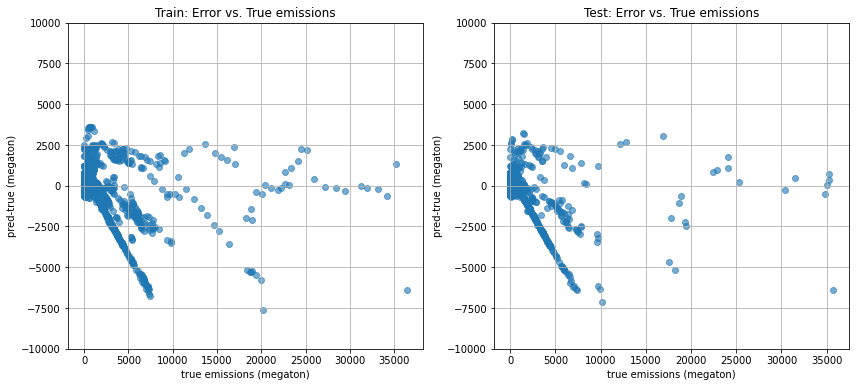

In [34]:
ridge_rgns = Ridge(alpha=0.01, 
                   fit_intercept=True, 
                   normalize=True)

ridge_rgns.fit(x_rgns_train,y_rgns_train)
# predict
y_rgns_ridge_pred_train = ridge_rgns.predict(x_rgns_train)
y_rgns_ridge_pred_test = ridge_rgns.predict(x_rgns_test)

# plot the results
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.scatter(x=y_rgns_train,y=(y_rgns_ridge_pred_train-y_rgns_train),alpha=0.6) #/y_fea_5_train
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Train: Error vs. True emissions')
plt.ylim([-10000,10000])
plt.grid('on')

plt.subplot(122)
plt.scatter(x=y_rgns_test,y=(y_rgns_ridge_pred_test-y_rgns_test),alpha=0.6) #/y_fea_5_test
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Test: Error vs. True emissions')
plt.ylim([-10000,10000])
plt.grid('on')


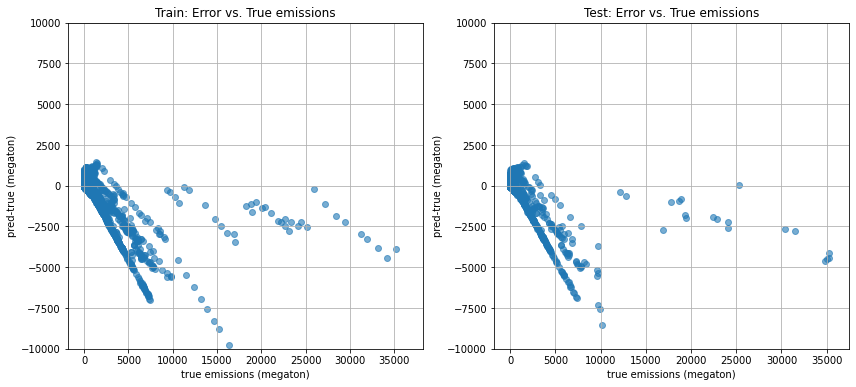

In [35]:
ridge_rgns = Ridge(alpha=1, 
                   fit_intercept=True, 
                   normalize=True)

ridge_rgns.fit(x_rgns_train,y_rgns_train)
# predict
y_rgns_ridge_pred_train = ridge_rgns.predict(x_rgns_train)
y_rgns_ridge_pred_test = ridge_rgns.predict(x_rgns_test)

# plot the results
plt.figure(figsize=(14,6))

plt.subplot(121)
plt.scatter(x=y_rgns_train,y=(y_rgns_ridge_pred_train-y_rgns_train),alpha=0.6) #/y_fea_5_train
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Train: Error vs. True emissions')
plt.ylim([-10000,10000])
plt.grid('on')

plt.subplot(122)
plt.scatter(x=y_rgns_test,y=(y_rgns_ridge_pred_test-y_rgns_test),alpha=0.6) #/y_fea_5_test
plt.xlabel('true emissions (megaton)')
plt.ylabel('pred-true (megaton)')
plt.title('Test: Error vs. True emissions')
plt.ylim([-10000,10000])
plt.grid('on')


In [36]:
df_coeff

,features,Linear,Lasso_a_1e-05,Lasso_a_3.5938136638046256e-05,Lasso_a_0.0001291549665014884,Lasso_a_0.0004641588833612782,Lasso_a_0.0016681005372000592,Lasso_a_0.005994842503189409,Lasso_a_0.021544346900318846,Lasso_a_0.07742636826811278,Lasso_a_0.2782559402207126,Lasso_a_1.0,Ridge_a_1e-05,Ridge_a_3.5938136638046256e-05,Ridge_a_0.0001291549665014884,Ridge_a_0.0004641588833612782,Ridge_a_0.0016681005372000592,Ridge_a_0.005994842503189409,Ridge_a_0.021544346900318846,Ridge_a_0.07742636826811278,Ridge_a_0.2782559402207126,Ridge_a_1.0
0,primary_energy_consumption_10Gwh,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02,8.454049e-02
1,gdp,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11,1.935914e-11
2,population,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06,2.847385e-06
3,Value_agri_1000hectare,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03,-2.105795e-03
4,Value_beef_tonnes,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04,2.762239e-04
5,energy_isnan,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01,1.272598e+01
6,gdp_isnan,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01,4.864060e+01
7,population_isnan,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02,6.493417e+02
8,argi_isnan,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01,6.596098e+01
9,beef_isnan,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01,-1.076728e+01


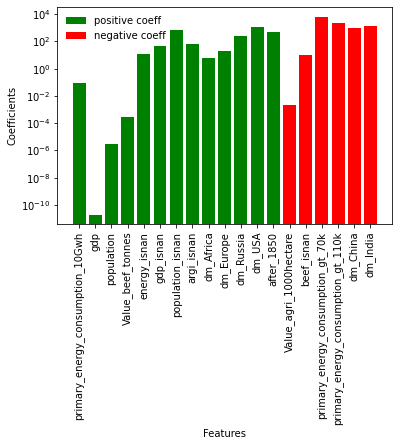

In [37]:
plt.bar(df_coeff['features'][df_coeff['Linear']>0],df_coeff['Linear'][df_coeff['Linear']>0],color='green',label='positive coeff')
plt.bar(df_coeff['features'][df_coeff['Linear']<=0],-df_coeff['Linear'][df_coeff['Linear']<=0],color='red',label='negative coeff')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.yscale('log') 
plt.xticks(rotation='vertical')
plt.legend(framealpha=0.0)
plt.show()

## 2.4 Save the data 

In [38]:
# save the data to a new csv file
# datapath = '../data'
# save_file(co2_data_df, 'co2_data_updated_v2.csv', datapath)

In [39]:
# !!! (residue plot => feature engi.)
# !!! any insight i can gain from this porject, talk about coeff. of my model.